# Analyse du dataset SpeedDating

---

preferences hommes/femmes dans les activités,

preferences dans les critères recherchés, évolution des préférences.

---

## preliminaires

In [247]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [248]:
sd = pd.read_csv('Speed Dating Data.csv', encoding = "cp1252", engine='python')

In [249]:
sd.shape

(8378, 195)

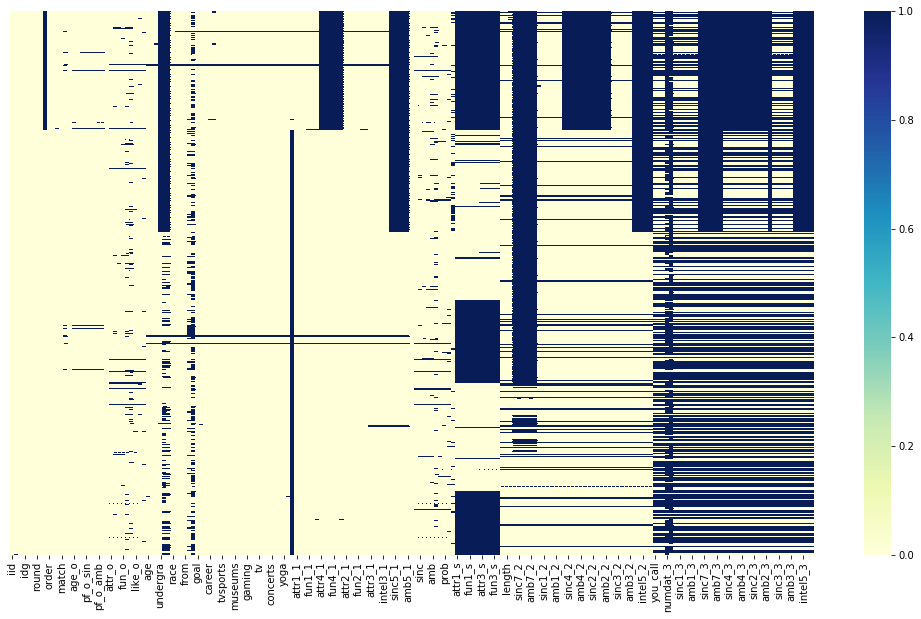

In [250]:
fig, ax = plt.subplots(figsize=(18,10))
_ = sns.heatmap(sd.isnull(), cmap="YlGnBu", yticklabels=False, ax=ax)

_méfiance_ il y a beaucoup de na.s ...

In [251]:
print("Nombre de femmes (0) : {}".format(len(sd.groupby(['gender'])['iid'].unique()[0])))
print("Nombre d'hommes (1) : {}".format(len(sd.groupby(['gender'])['iid'].unique()[1])))

Nombre de femmes (0) : 274
Nombre d'hommes (1) : 277


le dataset est bien équilibré hommes/femmes.

la répartition **des ages par genre** ci dessous fait aparaitre qques outlier, qu'on va garder.

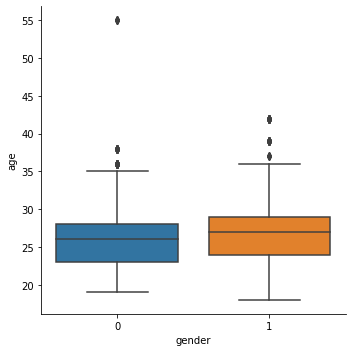

In [252]:
_ = sns.catplot(x="gender", y="age", kind="box", data=sd)

La répartition par ethnie et age est équillibrée.

_on remarque l'absence de "Native Americans"_

* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6

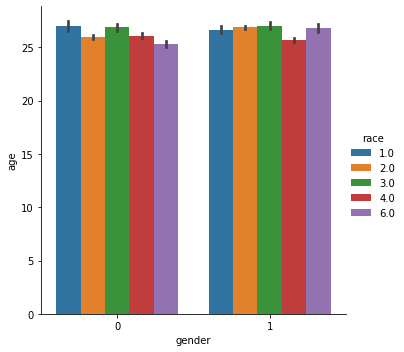

In [253]:
_ = sns.catplot(x="gender", y="age", hue='race', kind="bar", data=sd)

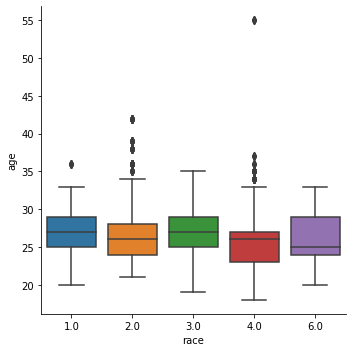

In [254]:
_ = sns.catplot(x='race', y='age', data=sd, kind='box')

l'origine géographique est une saisie libre, necessiterai du travail pour exploiter

In [255]:
sd['from'].unique()[:20]

array(['Chicago', 'Alabama', 'Connecticut', 'Texas', 'Bowdoin College',
       'MD', 'Southern California', 'London, England',
       'Palm Springs, California', '94115', 'Argentina', 'England',
       'Cincinnati, Ohio', 'Miami', 'Milan - Italy', 'Georgia, USA',
       'New York', 'california', 'Washington DC', 'New Jersey'],
      dtype=object)

par exemple, la variété des origines semble plus grande dans les groupes Européens et Asiatiques

In [256]:
[len(i) for i in sd.groupby('race')['from'].unique()]

[21, 168, 30, 86, 33]

## 21 sessions de rencontres ou Waves

On trouve quelques écarts entre le nombre de fille/garcons par wave dans le dataset et le document word.

par exemple sessions 20, 19, 17, 12

on peut supposer qu'un candidat ne s'est pas présenté, ou que ses données n'ai pas été ajoutées dans le dataset.

In [257]:
sd.groupby('wave')['round'].unique()

wave
1         [10]
2     [16, 19]
3         [10]
4         [18]
5         [10]
6          [5]
7         [16]
8         [10]
9         [20]
10         [9]
11        [21]
12        [14]
13     [9, 10]
14    [18, 20]
15    [19, 18]
16      [8, 6]
17    [14, 11]
18         [6]
19        [15]
20      [7, 6]
21        [22]
Name: round, dtype: object

on visualise la quantité de RDV en "speedating" à chaque session 

_la session 5 presente une anomalie, necessiterai d'être investigué_ 

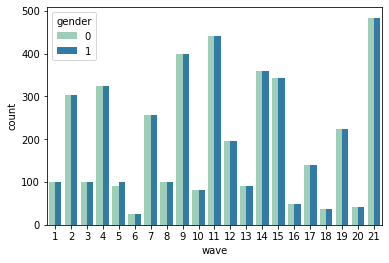

In [258]:
_ = sns.countplot(x='wave', data=sd, hue="gender", palette='YlGnBu')

## signup/Time

chaque candidat a rempli une fois le formulaire (admission), essayons d'extraire ces données spécifiquement.

In [259]:
signup = pd.DataFrame(sd[['iid', 'gender', 'wave']])
signup = signup.join(sd.iloc[:, 33:97])
signup.shape

(8378, 67)

In [260]:
signup = signup.drop_duplicates()
signup.shape

(551, 67)

In [261]:
277+274 # hommes + femmes

551

_remarque : on pourrait allèger le dataset en retirant ces données_

In [262]:
sd.drop(signup.columns[3:], axis=1, inplace=False).shape

(8378, 131)

---

**Petite digression sur l'usage RAM...**

In [263]:
sd_light = sd.drop(signup.columns[3:], axis=1, inplace=False)

In [264]:
print("Le dataset {} occupe {} Mo en mémoire".format("sd", round(sd.memory_usage(index=True, deep=True).sum()/1024/1024, 2)))
print("Le dataset {} occupe {} Mo en mémoire".format("signup", round(signup.memory_usage(index=True, deep=True).sum()/1024/1024, 2)))
print("Le dataset {} occupe {} Mo en mémoire".format("sd_light", round(sd_light.memory_usage(index=True, deep=True).sum()/1024/1024, 2)))

Le dataset sd occupe 15.68 Mo en mémoire
Le dataset signup occupe 0.5 Mo en mémoire
Le dataset sd_light occupe 8.37 Mo en mémoire


_rappel : le fichier .csv occupe 4.95 Mo sur disque._

In [265]:
del(sd_light)

---

**on continue l'exploration des données du signup**

retirer les virgules (,) avant de convertir en nombre/float

In [266]:
signup.mn_sat = signup.mn_sat.apply(lambda x : ''.join(str(x).split(','))).astype('float')
signup.tuition = signup.tuition.apply(lambda x : ''.join(str(x).split(','))).astype('float')
signup.income = signup.income.apply(lambda x : ''.join(str(x).split(','))).astype('float')

trop de n.a. pour être utilement analysé

passons ...

Il semble que les femmes accordent plus d'importance à la similarité ethnique.

* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6

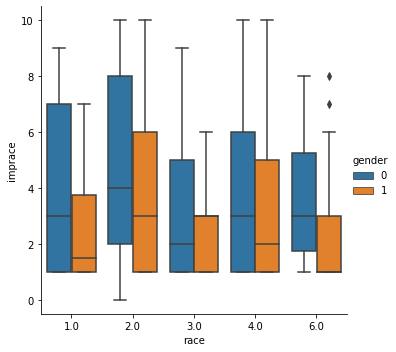

In [267]:
_ = sns.catplot(x='race', y='imprace', data=signup, kind='box', hue='gender')

... ainsi qu'à la religion.

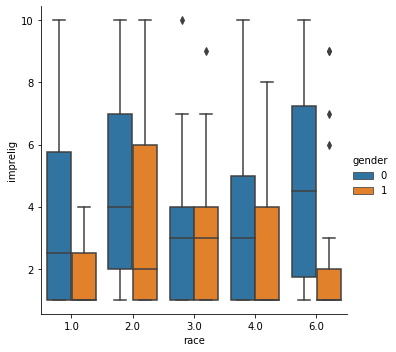

In [268]:
_ = sns.catplot(x='race', y='imprelig', data=signup, kind='box', hue='gender')

**Explorons les critères de recherche exprimés lors du signup**

on calcule la moyenne des notes pour chaque critère.

In [269]:
one = signup.groupby('gender')[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].mean().reset_index().melt(id_vars=['gender'])
four = signup.groupby('gender')[['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']].mean().reset_index().melt(id_vars=['gender'])
two = signup.groupby('gender')[['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].mean().reset_index().melt(id_vars=['gender'])
three = signup.groupby('gender')[['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']].mean().reset_index().melt(id_vars=['gender'])
five = signup.groupby('gender')[['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']].mean().reset_index().melt(id_vars=['gender'])

In [270]:
#avant le melt()
signup.groupby('gender')[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].mean().reset_index()

,gender,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,0,18.020372,18.22223,20.971004,17.299108,12.818476,12.697836
1,1,27.248800,16.37960,19.387418,17.600839,8.823956,10.982271


In [271]:
#après
one.head()

,gender,variable,value
0,0,attr1_1,18.020372
1,1,attr1_1,27.248800
2,0,sinc1_1,18.222230
3,1,sinc1_1,16.379600
4,0,intel1_1,20.971004


In [272]:
ylabels = {    
1 : "JE RECHERCHE",
2 : "LE GENRE OPPOSÉ RECHERCHE",
3 : "JE PENSE DE MOI",
4 : "MON GENRE RECHERCHE",
5 : "JE PENSE QU'ON PERCOIT DE MOI",
6 : "JE PENSE AVOIR RECHERCHÉ"
    }

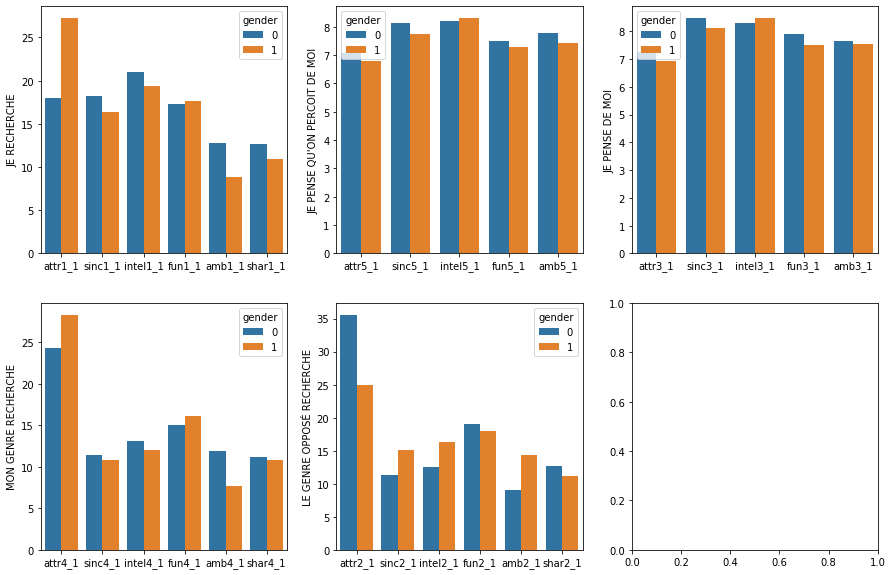

In [273]:
fig, ax = plt.subplots(2,3, figsize = (15, 10))

for i,data in zip((1,2,3,4,5), (one, two, three, four, five)):
    axes = (i-1)%2, (i-1)%3
    sns.barplot(x='variable', y='value', data=data, hue='gender', ax=ax[axes])

    ax[axes].set(xlabel='', ylabel=ylabels[i])
    
plt.show()

"conclusion" (à creuser):

* Les femmes (et les hommes) sont bien renseignés sur ce que cherchent les hommes (ou les femmes) (attr, ambition, ..)

* Par contre les femmes pense que les autres femmes pensent le contraire (attraction inavouée pour le physique? :) ... Les hommmes sont plus consistants dans leurs suppositions.


### SCORECARD

In [274]:
sd[(sd['match'] == 1) & (sd['dec'] == 1)][['iid', 'pid']].drop_duplicates()
# couples qui ont matchés

,iid,pid
2,1,13.0
3,1,14.0
4,1,15.0
8,1,19.0
13,2,14.0
...,...,...
8357,552,510.0
8360,552,513.0
8362,552,515.0
8363,552,516.0


Est ce que l'écart d'age joue en faveur du match ?

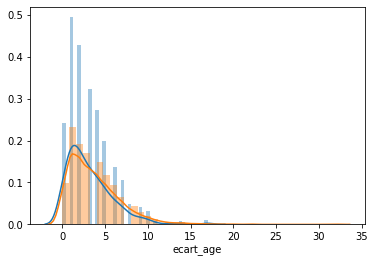

In [275]:
match_bool_mask = (sd['match'] == 1) & (sd['dec'] == 1)

matches = sd[match_bool_mask][['iid', 'pid', 'age', 'age_o']].drop_duplicates()
non_matches = sd[~match_bool_mask][['iid', 'pid', 'age', 'age_o']].drop_duplicates()

matches['ecart_age'] = abs(matches.age - matches.age_o)
non_matches['ecart_age'] = abs(non_matches.age - non_matches.age_o)

_ = sns.distplot(matches.ecart_age, bins=40)
_ = sns.distplot(non_matches.ecart_age, bins=40)

## follow up time

In [276]:
prefix = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']
ylabels

{1: 'JE RECHERCHE',
 2: 'LE GENRE OPPOSÉ RECHERCHE',
 3: 'JE PENSE DE MOI',
 4: 'MON GENRE RECHERCHE',
 5: "JE PENSE QU'ON PERCOIT DE MOI",
 6: 'JE PENSE AVOIR RECHERCHÉ'}

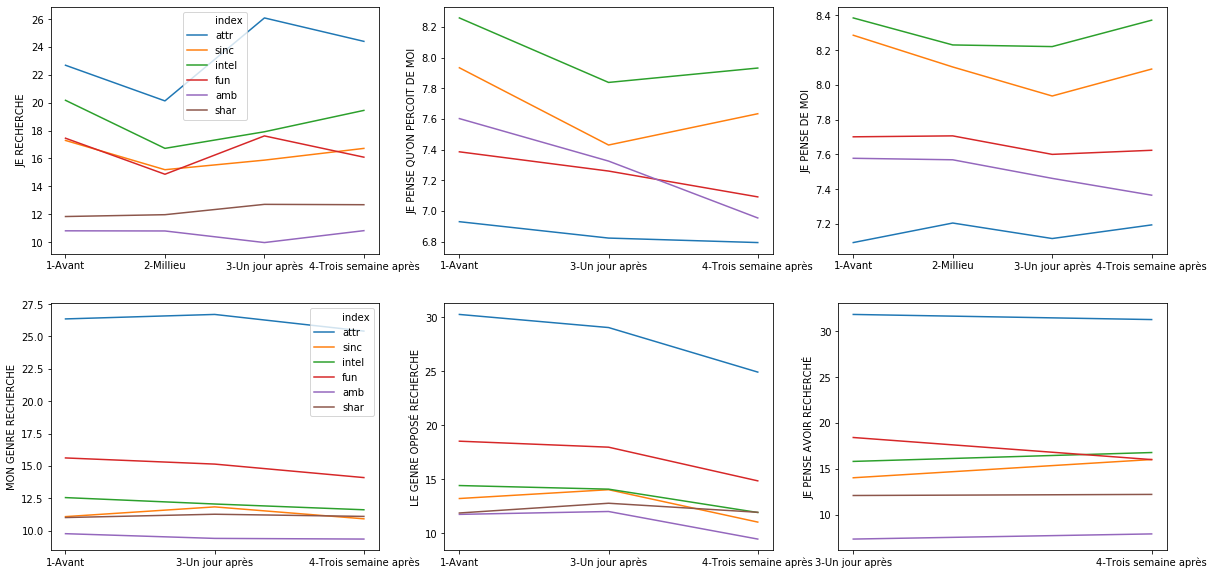

In [277]:
fig, ax = plt.subplots(2,3, figsize = (20, 10))

for z in [1,2, 3, 4, 5, 7]:

    if z in (1,3):
        labels = ['1-Avant','2-Millieu','3-Un jour après','4-Trois semaine après']
    elif z in (2,4,5):
        labels = ['1-Avant', '3-Un jour après','4-Trois semaine après']
    elif z == 7:
        labels = ['3-Un jour après','4-Trois semaine après']
    
    tmp = pd.DataFrame([], columns=labels)
    
    for prefix_ in prefix:
        if (z in [3, 5]) and (prefix_ == 'shar'): continue
        i = sd[
            sd.columns[
            sd.columns.str.startswith('iid') |
            sd.columns.str.startswith(prefix_ + str(z))
        ]].drop_duplicates().mean()[1:]
    
        i.index = labels
        i.name = prefix_
        tmp = tmp.append(i)

    tmp = tmp.reset_index()
    tmp = tmp.melt(id_vars=['index'], value_vars=labels, value_name='valeur')
    
    if z == 7: z = 6
    axes = (z-1)%2, (z-1)%3
    
    sns.lineplot(x = 'variable', y = 'valeur', 
                 data = tmp, 
                 hue = 'index', 
                 ax = ax[axes],
                 legend = ((z in (1,4)) and 'brief' or False))
    
    ax[axes].set(xlabel='', ylabel=ylabels[z])

plt.show()

Ces graphiques montrent l'évolution du score (moyen) de chaque critére dans le temps.

Montrent qques pistes de recherche à approfondir.

---

_annexe pour explication du code_

In [278]:
for z in [1,2, 3, 4, 5, 7]:

    if z in (1,3):
        labels = ['1-Avant','2-Millieu','3-Un jour après','4-Trois semaine après']
    elif z in (2,4,5):
        labels = ['1-Avant', '3-Un jour après','4-Trois semaine après']
    elif z == 7:
        labels = ['3-Un jour après','4-Trois semaine après']
    
    tmp = pd.DataFrame([], columns=labels)
    
    for prefix_ in prefix:
        if (z in [3, 5]) and (prefix_ == 'shar'): continue
        i = sd[
            sd.columns[
            sd.columns.str.startswith('iid') |
            sd.columns.str.startswith(prefix_ + str(z))
        ]].drop_duplicates().mean()[1:]
        
#        i.index = labels
#        i.name = prefix_
        print(i)
        print()

attr1_1    22.685478
attr1_s    20.127722
attr1_2    26.080227
attr1_3    24.398935
dtype: float64

sinc1_1    17.290754
sinc1_s    15.190996
sinc1_2    15.877856
sinc1_3    16.720494
dtype: float64

intel1_1    20.170478
intel1_s    16.722669
intel1_2    17.912825
intel1_3    19.446578
dtype: float64

fun1_1    17.451363
fun1_s    14.865658
fun1_2    17.615402
fun1_3    16.089582
dtype: float64

amb1_1    10.806476
amb1_s    10.795730
amb1_2     9.964103
amb1_3    10.818023
dtype: float64

shar1_1    11.832126
shar1_s    11.963381
shar1_2    12.704722
shar1_3    12.679506
dtype: float64

attr2_1    30.248033
attr2_2    29.035870
attr2_3    24.917098
dtype: float64

sinc2_1    13.226581
sinc2_2    14.042799
sinc2_3    11.046632
dtype: float64

intel2_1    14.426048
intel2_2    14.092255
intel2_3    11.932642
dtype: float64

fun2_1    18.527684
fun2_2    17.974158
fun2_3    14.860104
dtype: float64

amb2_1    11.760074
amb2_2    12.025571
amb2_3     9.476684
dtype: float64

shar2_1    1

In [279]:
for z in [1,2, 3, 4, 5, 7]:

    if z in (1,3):
        labels = ['1-Avant','2-Millieu','3-Un jour après','4-Trois semaine après']
    elif z in (2,4,5):
        labels = ['1-Avant', '3-Un jour après','4-Trois semaine après']
    elif z == 7:
        labels = ['3-Un jour après','4-Trois semaine après']
    
    tmp = pd.DataFrame([], columns=labels)
    
    for prefix_ in prefix:
        if (z in [3, 5]) and (prefix_ == 'shar'): continue
        i = sd[
            sd.columns[
            sd.columns.str.startswith('iid') |
            sd.columns.str.startswith(prefix_ + str(z))
        ]].drop_duplicates().mean()[1:]
    
        i.index = labels
        i.name = prefix_
        tmp = tmp.append(i)

    tmp = tmp.reset_index()
    tmp = tmp.melt(id_vars=['index'], value_vars=labels, value_name='valeur')
    
    print("dataframe de {}".format(ylabels[z]))
    print(tmp)
    print()

dataframe de JE RECHERCHE
    index               variable     valeur
0    attr                1-Avant  22.685478
1    sinc                1-Avant  17.290754
2   intel                1-Avant  20.170478
3     fun                1-Avant  17.451363
4     amb                1-Avant  10.806476
5    shar                1-Avant  11.832126
6    attr              2-Millieu  20.127722
7    sinc              2-Millieu  15.190996
8   intel              2-Millieu  16.722669
9     fun              2-Millieu  14.865658
10    amb              2-Millieu  10.795730
11   shar              2-Millieu  11.963381
12   attr        3-Un jour après  26.080227
13   sinc        3-Un jour après  15.877856
14  intel        3-Un jour après  17.912825
15    fun        3-Un jour après  17.615402
16    amb        3-Un jour après   9.964103
17   shar        3-Un jour après  12.704722
18   attr  4-Trois semaine après  24.398935
19   sinc  4-Trois semaine après  16.720494
20  intel  4-Trois semaine après  19.446578
21    

KeyError: 7

---

## complément analyse : les préferences par activité

On selectionne les colonnes qui nous interessent (sports, ..).

ainsi que quelques features propres à l'individu. (iid, genre, ...)


In [280]:
ind_labels = ['iid', 'gender', 'race', 'age', 'field']
act_labels = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']

act = sd[ind_labels + act_labels].drop_duplicates()

# on ajoute une feature "groupe d'age". 18, 24, 30, 36.
act['age_g'] = 6 * (act.age // 6)

print(act.shape)
act.head()

(551, 23)


,iid,gender,race,age,field,sports,tvsports,exercise,dining,museums,...,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,age_g
0,1,0,4.0,21.0,Law,9.0,2.0,8.0,9.0,1.0,...,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,18.0
10,2,0,2.0,24.0,law,3.0,2.0,7.0,10.0,8.0,...,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,24.0
20,3,0,2.0,25.0,Economics,3.0,8.0,7.0,8.0,5.0,...,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,24.0
30,4,0,2.0,23.0,Law,1.0,1.0,6.0,7.0,6.0,...,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0,18.0
40,5,0,2.0,21.0,Law,7.0,4.0,7.0,7.0,6.0,...,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0,18.0


On calcule les moyennes par colonnes.

Puis on rè-organise le DataFrame.

In [281]:
tmp = act.groupby(['gender', 'age_g'])[act_labels].mean().reset_index()
activities = tmp.melt(id_vars=['gender', 'age_g'], value_vars=act_labels, var_name='activity')
activities.head()

,gender,age_g,activity,value
0,0,18.0,sports,6.162162
1,0,24.0,sports,5.802632
2,0,30.0,sports,4.947368
3,0,36.0,sports,3.666667
4,0,54.0,sports,1.000000


On peut maintenant visualiser les préférences par genre.

Surprise les femmes sont moins attirées que les hommes par le gaming, mais plus par les musées et l'art.

Les clichés habituels sont bien représentés ici.

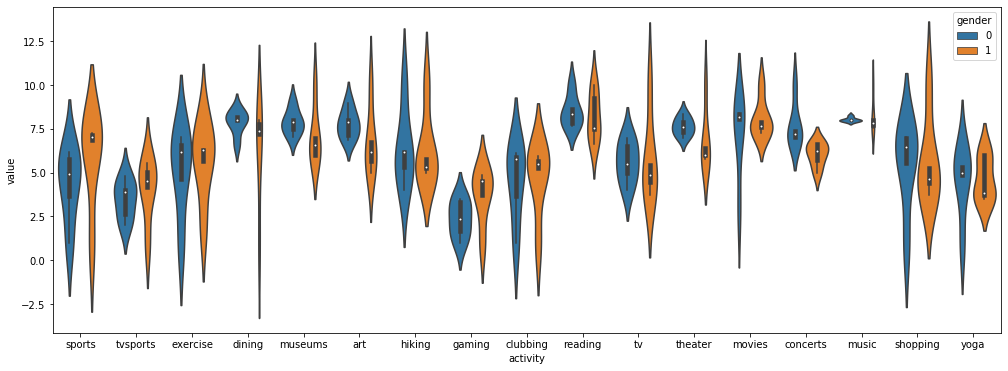

In [282]:
fig, ax = plt.subplots(figsize=(17,6))
_ = sns.violinplot(x='activity', y='value', data=activities, hue='gender', ax=ax)

Voyons si les clichés de classe d'age sont présents.

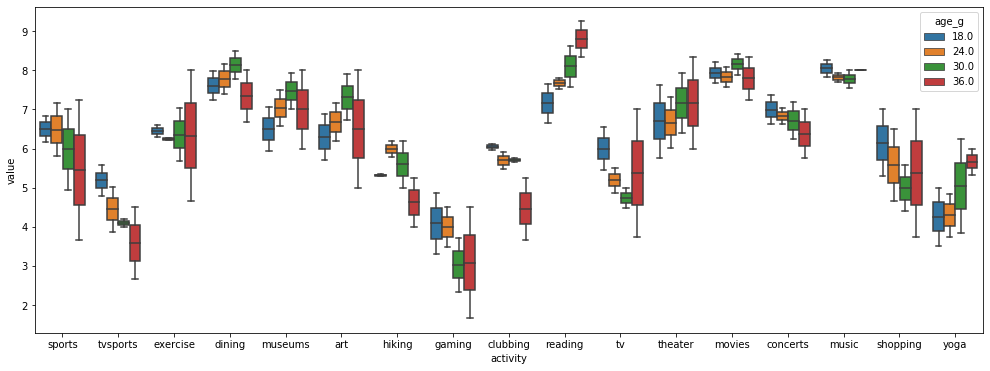

In [283]:
fig, ax = plt.subplots(figsize=(17,6))
_ = sns.boxplot(x='activity', y='value', data=activities[activities.age_g < 40], hue='age_g', ax=ax)

Conclusion : 
Après qques heures passèes sur le dataset, on commence à comprendre comment il est organisé.

Il reste un travail important pour analyser les matches (et non-matches).

In [291]:
import datetime
print(datetime.datetime.now())

2020-04-27 15:36:06.161544


last update : 2020-04-27 15:36:06.161544